In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
sys.path.insert(0, '..')
tqdm.pandas()

In [3]:
from functions.data_prepare import prepare_dataset, get_doc_text, prepare_sents_dataset
from functions.utils import save_file

In [4]:
from jupyterthemes import jtplot
jtplot.reset()
sns.set(rc={'figure.figsize': (6, 4)})

In [5]:
CONTRACT_PATH = Path('../docs')
target_fn = 'classes.json'

In [6]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 1 - TRAIN_SIZE - VAL_SIZE

SEED = 42

Посмотрим на мета-данные, которые отдает tika:

In [7]:
fn = 'ef140e96384a29057445d0a889f1ad50.doc'

In [8]:
with open(CONTRACT_PATH / fn, 'rb') as f:
    ret = get_doc_text(f, return_meta=True)

In [9]:
[{k: v} for k, v in ret['metadata'].items() if 'title' in k]

[{'dc:title': 'ДОГОВОР (СУБ) АРЕНДЫ НЕЖИЛЫХ ПОМЕЩЕНИЙ №  ______'},
 {'title': 'ДОГОВОР (СУБ) АРЕНДЫ НЕЖИЛЫХ ПОМЕЩЕНИЙ №  ______'}]

In [10]:
[{k: v} for k, v in ret['metadata'].items() if 'date' in k]

[{'date': '2022-12-08T14:16:00Z'},
 {'meta:creation-date': '2008-10-02T10:28:00Z'},
 {'meta:save-date': '2022-12-08T14:16:00Z'}]

## Формирование датасета

In [11]:
docs_df = prepare_dataset(CONTRACT_PATH)

Total documents: 120


DOC/DOCX/PDF/RTF Reading: 100%|██████████████| 120/120 [00:09<00:00, 12.86it/s]


In [12]:
docs_df.head()

,FileName,Format,Content
0,02682d726b725f95b9ee85f751c043d0.doc,doc,ДОГОВОР № ______\n\nДОГОВОР\n\nг. Москва\n«___...
1,03a70fe60be9ecc2a63798a361fc9689.docx,docx,ДОГОВОР \n\n№ ______ от «___» ___________ ____...
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,doc,ДОГОВОР КУПЛИ-ПРОДАЖИ КВАРТИРЫ\n\n\nДОГОВОР \n...
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,doc,Договор аренды земельного участка\n\n2\n5\n\nД...
4,086ad48895d2a73854b6151decc28800.pdf,pdf,(Типовая форма) \n\nДОГОВОР КУПЛИ-ПРОДАЖИ №___...


In [13]:
print('Количество пустых документов:', (docs_df.Content == '').sum())
if (docs_df.Content == '').sum() > 0:
    for fn in docs_df[docs_df.Content == ''].FileName.values:
        print('\t', fn)

Количество пустых документов: 0


In [14]:
with open(CONTRACT_PATH / target_fn, 'r', encoding='utf-8') as json_file:
    target_dict = json.load(json_file)

In [15]:
docs_df['target'] = docs_df.FileName.map(target_dict)

In [16]:
docs_df.head()

,FileName,Format,Content,target
0,02682d726b725f95b9ee85f751c043d0.doc,doc,ДОГОВОР № ______\n\nДОГОВОР\n\nг. Москва\n«___...,Договоры для акселератора/Договоры оказания услуг
1,03a70fe60be9ecc2a63798a361fc9689.docx,docx,ДОГОВОР \n\n№ ______ от «___» ___________ ____...,Договоры для акселератора/Договоры подряда
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,doc,ДОГОВОР КУПЛИ-ПРОДАЖИ КВАРТИРЫ\n\n\nДОГОВОР \n...,Договоры для акселератора/Договоры купли-продажи
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,doc,Договор аренды земельного участка\n\n2\n5\n\nД...,Договоры для акселератора/Договоры аренды
4,086ad48895d2a73854b6151decc28800.pdf,pdf,(Типовая форма) \n\nДОГОВОР КУПЛИ-ПРОДАЖИ №___...,Договоры для акселератора/Договоры купли-продажи


In [17]:
docs_df.shape[0]

120

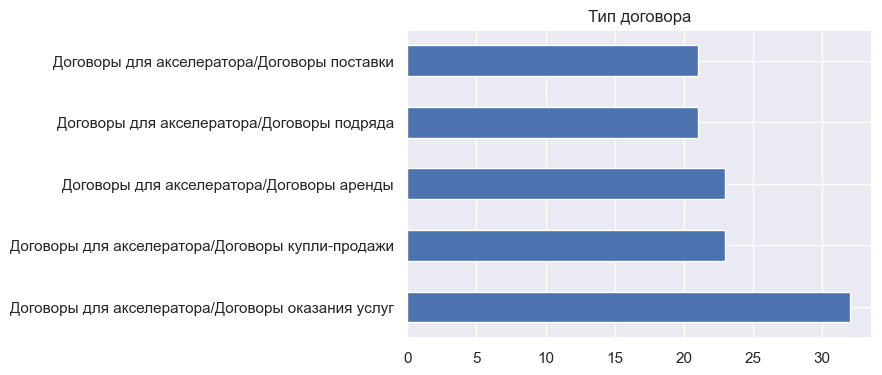

In [18]:
docs_df.target.value_counts().plot(kind='barh')
plt.title('Тип договора')
plt.show()

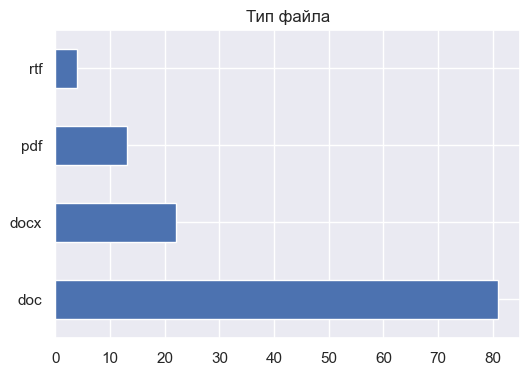

In [19]:
docs_df.Format.value_counts().plot(kind='barh')
plt.title('Тип файла')
plt.show()

In [20]:
docs_df['ContLen'] = docs_df.Content.apply(lambda x: len(x.split()))

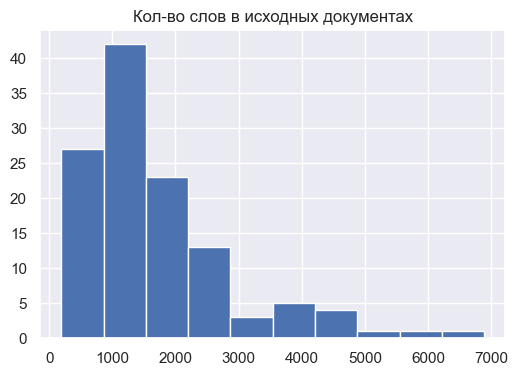

In [21]:
plt.hist(docs_df['ContLen'])
plt.title('Кол-во слов в исходных документах')
plt.show()

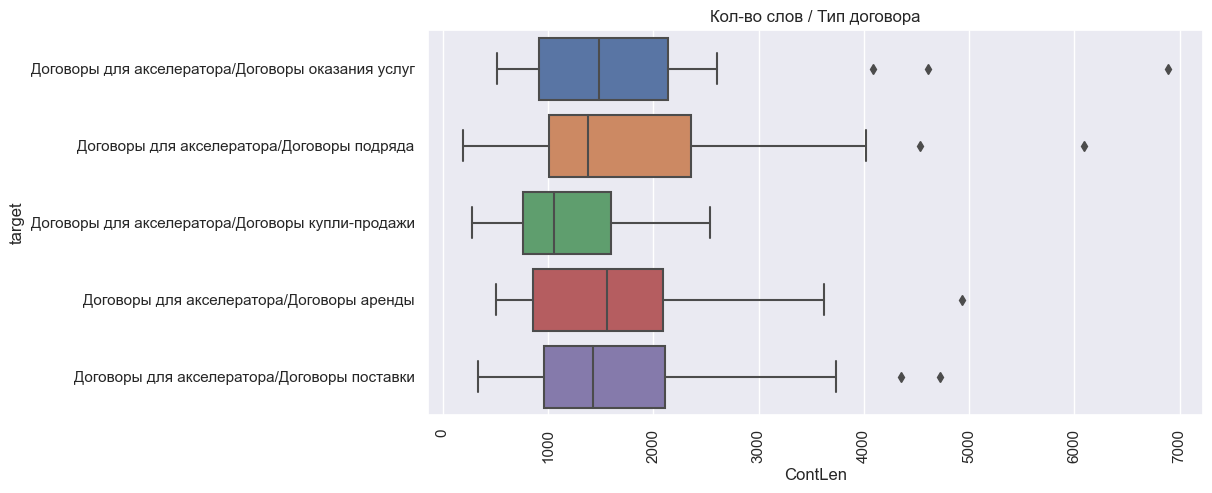

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=docs_df, y='target', x='ContLen', orient='h')
plt.xticks(rotation=90)
plt.title('Кол-во слов / Тип договора')
plt.show()

In [23]:
docs_df.head()

,FileName,Format,Content,target,ContLen
0,02682d726b725f95b9ee85f751c043d0.doc,doc,ДОГОВОР № ______\n\nДОГОВОР\n\nг. Москва\n«___...,Договоры для акселератора/Договоры оказания услуг,2144
1,03a70fe60be9ecc2a63798a361fc9689.docx,docx,ДОГОВОР \n\n№ ______ от «___» ___________ ____...,Договоры для акселератора/Договоры подряда,1011
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,doc,ДОГОВОР КУПЛИ-ПРОДАЖИ КВАРТИРЫ\n\n\nДОГОВОР \n...,Договоры для акселератора/Договоры купли-продажи,922
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,doc,Договор аренды земельного участка\n\n2\n5\n\nД...,Договоры для акселератора/Договоры аренды,2281
4,086ad48895d2a73854b6151decc28800.pdf,pdf,(Типовая форма) \n\nДОГОВОР КУПЛИ-ПРОДАЖИ №___...,Договоры для акселератора/Договоры купли-продажи,1609


In [24]:
train_all, test_idx = train_test_split(docs_df.index, test_size=int(TEST_SIZE * docs_df.shape[0]), shuffle=True,
                                       stratify=docs_df.target, random_state=SEED)

train_idx, val_idx = train_test_split(train_all, train_size=int(TRAIN_SIZE * docs_df.shape[0]), shuffle=True,
                                      stratify=docs_df[docs_df.index.isin(train_all)].target, random_state=SEED)

In [25]:
len(train_idx), len(val_idx), len(test_idx)

(84, 18, 18)

In [26]:
docs_df.loc[docs_df.index.isin(train_idx), 'Split'] = 'train'
docs_df.loc[docs_df.index.isin(val_idx), 'Split'] = 'val'
docs_df.loc[docs_df.index.isin(test_idx), 'Split'] = 'test'

In [27]:
docs_df.head()

,FileName,Format,Content,target,ContLen,Split
0,02682d726b725f95b9ee85f751c043d0.doc,doc,ДОГОВОР № ______\n\nДОГОВОР\n\nг. Москва\n«___...,Договоры для акселератора/Договоры оказания услуг,2144,train
1,03a70fe60be9ecc2a63798a361fc9689.docx,docx,ДОГОВОР \n\n№ ______ от «___» ___________ ____...,Договоры для акселератора/Договоры подряда,1011,val
2,073a0d372820c3c2bffe9ba24a7ed7af.doc,doc,ДОГОВОР КУПЛИ-ПРОДАЖИ КВАРТИРЫ\n\n\nДОГОВОР \n...,Договоры для акселератора/Договоры купли-продажи,922,val
3,084edc7dfc3db04e3a3c55c102f47bcb.doc,doc,Договор аренды земельного участка\n\n2\n5\n\nД...,Договоры для акселератора/Договоры аренды,2281,val
4,086ad48895d2a73854b6151decc28800.pdf,pdf,(Типовая форма) \n\nДОГОВОР КУПЛИ-ПРОДАЖИ №___...,Договоры для акселератора/Договоры купли-продажи,1609,val


In [28]:
docs_df.Split.value_counts()

train    84
val      18
test     18
Name: Split, dtype: int64

In [29]:
docs_df.groupby('Split').target.value_counts(normalize=True)

Split  target                                           
test   Договоры для акселератора/Договоры оказания услуг    0.277778
       Договоры для акселератора/Договоры купли-продажи     0.222222
       Договоры для акселератора/Договоры аренды            0.166667
       Договоры для акселератора/Договоры подряда           0.166667
       Договоры для акселератора/Договоры поставки          0.166667
train  Договоры для акселератора/Договоры оказания услуг    0.285714
       Договоры для акселератора/Договоры аренды            0.202381
       Договоры для акселератора/Договоры поставки          0.178571
       Договоры для акселератора/Договоры купли-продажи     0.166667
       Договоры для акселератора/Договоры подряда           0.166667
val    Договоры для акселератора/Договоры купли-продажи     0.277778
       Договоры для акселератора/Договоры подряда           0.222222
       Договоры для акселератора/Договоры аренды            0.166667
       Договоры для акселератора/Договоры оказ

In [30]:
sents_df = prepare_sents_dataset(docs_df, min_sym_cnt=100)

120it [00:01, 79.90it/s]


In [31]:
sents_df.head()

,file_name,snt_order,sentence,sentence_clear,data_split,target
0,02682d726b725f95b9ee85f751c043d0.doc,1,ДОГОВОР № ______ ДОГОВОР Москва «_____» ______...,договор договор москва года гражданин рф года ...,train,Договоры оказания услуг
1,02682d726b725f95b9ee85f751c043d0.doc,2,"Предмет Договора. 1.1. Заказчик поручает, а Ис...",предмет договора заказчик поручает а исполните...,train,Договоры оказания услуг
2,02682d726b725f95b9ee85f751c043d0.doc,3,Объект недвижимости находится на _____ этаже _...,объект недвижимости находится на этаже этажног...,train,Договоры оказания услуг
3,02682d726b725f95b9ee85f751c043d0.doc,4,Объект недвижимости не обременен правами други...,объект недвижимости не обременен правами други...,train,Договоры оказания услуг
4,02682d726b725f95b9ee85f751c043d0.doc,5,Требования Заказчика к условиям совершения сде...,требования заказчика к условиям совершения сде...,train,Договоры оказания услуг


In [32]:
sents_df.tail()

,file_name,snt_order,sentence,sentence_clear,data_split,target
7092,ff6882cb4a3ec31dec18a94e1d1745b1.doc,47,8.3. Настоящий договор действует до момента ок...,настоящий договор действует до момента окончан...,test,Договоры купли-продажи
7093,ff6882cb4a3ec31dec18a94e1d1745b1.doc,48,8.4. Настоящий договор не является заключенным...,настоящий договор не является заключенным с ус...,test,Договоры купли-продажи
7094,ff6882cb4a3ec31dec18a94e1d1745b1.doc,49,8.5. Настоящий договор подписан в двух экземпл...,настоящий договор подписан в двух экземплярах ...,test,Договоры купли-продажи
7095,ff6882cb4a3ec31dec18a94e1d1745b1.doc,50,"8.6. Во всем остальном, что не предусмотрено н...",во всем остальном что не предусмотрено настоящ...,test,Договоры купли-продажи
7096,ff6882cb4a3ec31dec18a94e1d1745b1.doc,51,9. Реквизиты Продавца и Покупателя Продавец: О...,реквизиты продавца и покупателя продавец огрн ...,test,Договоры купли-продажи


In [33]:
sents_df.sample(10)

,file_name,snt_order,sentence,sentence_clear,data_split,target
3330,736cc87395089b9611b0db70d2999d75.pdf,59,8. Дополнительные условия 8.1 ЗАКАЗЧИК обязует...,дополнительные условия заказчик обязуется раск...,train,Договоры оказания услуг
7060,ff6882cb4a3ec31dec18a94e1d1745b1.doc,15,2.2.5. Продавец имеет и иные права и обязаннос...,продавец имеет и иные права и обязанности пред...,test,Договоры купли-продажи
3503,79104075f8b2ff971d51c495e67af52c.pdf,20,Обеспечивать рекламно-информационную поддержку...,обеспечивать рекламно информационную поддержку...,train,Договоры поставки
145,084edc7dfc3db04e3a3c55c102f47bcb.doc,5,Кадастровый номер Участка - __________________...,кадастровый номер участка разрешенное использо...,val,Договоры аренды
3691,7a120d4c7cec157324effa671e2d0812.docx,121,6. Качество 6.1. На выполненную Работу по пред...,качество на выполненную работу по предмету дог...,val,Договоры подряда
3312,736cc87395089b9611b0db70d2999d75.pdf,41,Счет-фактура в электронном виде считается полу...,счет фактура в электронном виде считается полу...,train,Договоры оказания услуг
1062,259b481366842141111305897cce7486.docx,13,Сумма дополнительных расходов Исполнителя по д...,сумма дополнительных расходов исполнителя по д...,train,Договоры оказания услуг
5503,abcec818adbe358f8071a75e0fe2cc49.pdf,3,"1.2. Ассортимент, количество, цена единицы тов...",ассортимент количество цена единицы товара и о...,train,Договоры купли-продажи
1894,453b2cb6e4ba7b8d1a8382773880d313.doc,36,7.7. Стороны могут предусматривать в Заказах о...,стороны могут предусматривать в заказах особен...,train,Договоры подряда
317,0b4be82b86eff410d69d1d6b5553d220.docx,58,<8> Стороны по своему усмотрению вправе дополн...,стороны по своему усмотрению вправе дополнить ...,train,Договоры оказания услуг


In [34]:
sents_df['sent_clear_len'] = sents_df.sentence_clear.apply(lambda x: len(x.split()))

In [35]:
(sents_df.sent_clear_len == 0).sum()

7

In [36]:
sents_df = sents_df[sents_df.sent_clear_len > 0]

In [37]:
sents_df.shape[0]

7090

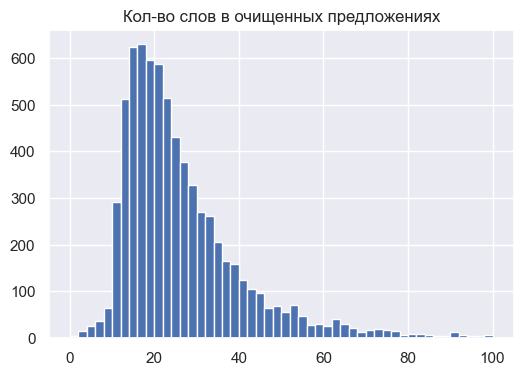

In [38]:
plt.hist(sents_df['sent_clear_len'], bins=50, range=(0, 100))
plt.title('Кол-во слов в очищенных предложениях')
plt.show()

In [39]:
np.quantile(sents_df['sent_clear_len'], [0.95, 0.99, 0.995])

array([ 56.  ,  92.  , 112.11])

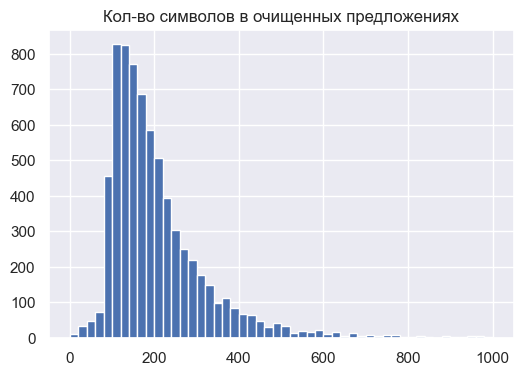

In [40]:
plt.hist(sents_df['sentence_clear'].apply(len), bins=50, range=(0, 1000))
plt.title('Кол-во символов в очищенных предложениях')
plt.show()

In [41]:
save_file(sents_df, CONTRACT_PATH / 'sents_df_100.pkl')

'Done'